In [2]:
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/sparg2.0")

import sparg
import tskit
import msprime
import math
import numpy as np
#import tskit_arg_visualizer as viz
import warnings
import matplotlib.pyplot as plt
import scipy.stats as st
warnings.simplefilter("always")


def simplify_with_recombination(ts, flag_recomb=False, keep_nodes=[]):
    """Simplifies a tree sequence while keeping recombination nodes

    Removes unary nodes that are not recombination nodes. Does not remove non-genetic ancestors.
    Edges intervals are not updated. This differs from how tskit's TreeSequence.simplify() works.

    Parameters
    ----------
    ts : tskit.TreeSequence
    flag_recomb : bool
        Whether to add msprime node flags

    Returns
    -------
    ts_sim : tskit.TreeSequence
        Simplified tree sequence
    maps_sim : numpy.ndarray
        Mapping for nodes in the simplified tree sequence versus the original
    """

    uniq_child_parent = np.unique(np.column_stack((ts.edges_child, ts.edges_parent)), axis=0)
    child_node, parents_count = np.unique(uniq_child_parent[:, 0], return_counts=True) #For each child, count how many parents it has.
    parent_node, children_count = np.unique(uniq_child_parent[:, 1], return_counts=True) #For each child, count how many parents it has.
    multiple_parents = child_node[parents_count > 1] #Find children who have more than 1 parent. 
    recomb_nodes = ts.edges_parent[np.in1d(ts.edges_child, multiple_parents)] #Find the parent nodes of the children with multiple parents. 
    
    if flag_recomb:
        ts_tables = ts.dump_tables()
        node_table = ts_tables.nodes
        flags = node_table.flags
        flags[recomb_nodes] = msprime.NODE_IS_RE_EVENT
        node_table.flags = flags
        ts_tables.sort() 
        ts = ts_tables.tree_sequence()
    
    #keep_nodes = np.unique(np.concatenate((np.where((ts.tables.nodes.time <= keep_nodes_below) & (ts.tables.nodes.time % keep_nodes_step == 0))[0], recomb_nodes)))
    keep_nodes = np.unique(np.concatenate((keep_nodes, recomb_nodes)))
    potentially_uninformative = np.intersect1d(child_node[np.where(parents_count!=0)[0]], parent_node[np.where(children_count==1)[0]])
    truly_uninformative = np.delete(potentially_uninformative, np.where(np.isin(potentially_uninformative, keep_nodes)))
    all_nodes = np.array(range(ts.num_nodes))
    important = np.delete(all_nodes, np.where(np.isin(all_nodes, truly_uninformative)))
    ts_sim, maps_sim = ts.simplify(samples=important, map_nodes=True, keep_input_roots=False, keep_unary=False, update_sample_flags=False)
    return ts_sim, maps_sim

def identify_all_nodes_above(ts, nodes):
    """Traverses all nodes above provided list of nodes

    Parameters
    ----------
    ts : tskit.TreeSequence
    nodes : list or numpy.ndarray
        Nodes to traverse above in the ARG. Do not need to be connected

    Returns
    -------
    above_samples : numpy.ndarray
        Sorted array of node IDs above the provided list of nodes
    """

    edges = ts.tables.edges
    above_samples = []
    while len(nodes) > 0:
        above_samples.append(nodes[0])
        parents = list(np.unique(edges[np.where(edges.child==nodes[0])[0]].parent))
        new_parents = []
        for p in parents:
            if (p not in nodes) and (p not in above_samples):
                new_parents.append(p)
        nodes = nodes[1:] + new_parents
    return np.sort(above_samples)

def chop_arg(ts, time):
    decap = ts.decapitate(time)
    subset = decap.subset(nodes=np.where(decap.tables.nodes.time <= time)[0])
    merged = sparg.merge_unnecessary_roots(ts=subset)
    return merged

In [7]:
ts = tskit.load("simple_space_uniform_start_rep1.trees")

np.random.seed(1)
samples = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)

In [8]:
d_file = np.genfromtxt("simple_space_uniform_start_50_seqlen_1_with_tree_average_chopped40K.txt", delimiter=" ")

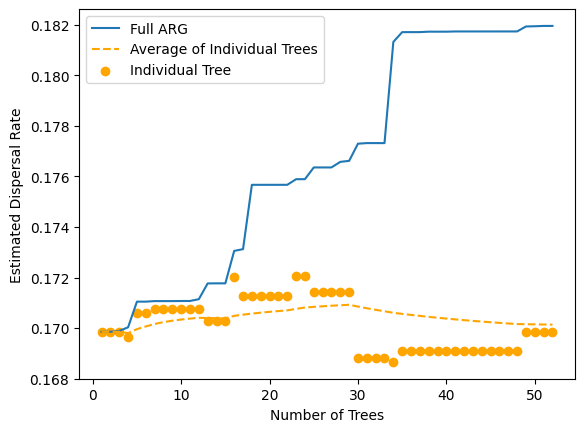

In [22]:
plt.plot(d_file[:,0], d_file[:,3], label="Full ARG")
plt.plot(d_file[:,0], d_file[:,9], color="orange", linestyle="dashed", label="Average of Individual Trees")
plt.scatter(d_file[:,0], d_file[:,6], color="orange", label="Individual Tree")
plt.xlabel("Number of Trees")
plt.ylabel("Estimated Dispersal Rate")
plt.legend()
plt.savefig("dispersal_rate_behavior.svg")